In [3]:
!pip install transformers datasets soundfile speechbrain accelerate
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel.yaml 0.17.32
    Uninstalling ruamel.yaml-0.17.32:
      Successfully uninstalled ruamel.yaml-0.17.32


In [4]:
!wget https://openslr.org/resources/44/su_id_female.zip

--2023-08-29 03:48:00--  https://openslr.org/resources/44/su_id_female.zip
Resolving openslr.org (openslr.org)... 46.101.158.64
Connecting to openslr.org (openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/44/su_id_female.zip [following]
--2023-08-29 03:48:01--  http://us.openslr.org/resources/44/su_id_female.zip
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 861425671 (822M) [application/zip]
Saving to: ‘su_id_female.zip’

su_id_female.zip    100%[===================>] 821.52M  12.7MB/s    in 67s     

2023-08-29 03:49:09 (12.2 MB/s) - ‘su_id_female.zip’ saved [861425671/861425671]



In [5]:
!unzip /kaggle/working/su_id_female.zip

Archive:  /kaggle/working/su_id_female.zip
   creating: su_id_female/
  inflating: su_id_female/line_index.tsv  
   creating: su_id_female/wavs/
  inflating: su_id_female/wavs/suf_00691_01638850580.wav  
  inflating: su_id_female/wavs/suf_00691_01612260265.wav  
  inflating: su_id_female/wavs/suf_00691_01601535903.wav  
  inflating: su_id_female/wavs/suf_00691_01548588150.wav  
  inflating: su_id_female/wavs/suf_00691_01507891938.wav  
  inflating: su_id_female/wavs/suf_00691_01438581447.wav  
  inflating: su_id_female/wavs/suf_00691_01385148819.wav  
  inflating: su_id_female/wavs/suf_00691_01373957239.wav  
  inflating: su_id_female/wavs/suf_00691_01372819842.wav  
  inflating: su_id_female/wavs/suf_00691_01369020465.wav  
  inflating: su_id_female/wavs/suf_00691_01366365436.wav  
  inflating: su_id_female/wavs/suf_00691_01336291917.wav  
  inflating: su_id_female/wavs/suf_00691_01316546669.wav  
  inflating: su_id_female/wavs/suf_00691_01297143283.wav  
  inflating: su_id_female/wav

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
import datasets
import librosa

from functools import partial
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from speechbrain.pretrained import EncoderClassifier
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from datasets import Dataset
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, Seq2SeqTrainingArguments, Seq2SeqTrainer, SpeechT5HifiGan
sns.set()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [42]:
notebook_login()

In [8]:
data = pd.read_csv("/kaggle/working/su_id_female/line_index.tsv", names=["path_wav", "kosong_2", "text"], sep="\t")
data

,path_wav,kosong_2,text
0,suf_00297_00037352660,NaN,Panonton ting haruleng ningali Kelly Clarkson ...
1,suf_00297_00058959617,NaN,Kompleks perumahan anu caket Padang agreng pisan
2,suf_00297_00113221565,NaN,Panonton ting haruleng ninggali Emilia Clarke ...
3,suf_00297_00116146701,NaN,Turis mancanagara keur ningali gerhana bulan p...
4,suf_00297_00151191469,NaN,Ayeuna omset Susu Murni Lembang ningkat dugi k...
...,...,...,...
2396,suf_08703_02084677228,NaN,Seniman nuju ngalukis Menchester
2397,suf_08703_02122812193,NaN,Turis mancanagara keur ningali gerhana bulan p...
2398,suf_08703_02125282333,NaN,Dina bulan Puasa taun salapan puluh genep seue...
2399,suf_08703_02140709144,NaN,Loba wartawan anu ngaguar lalampahan Bunga Cit...


In [9]:
data.drop(["kosong_2"], axis=1, inplace=True)
data

,path_wav,text
0,suf_00297_00037352660,Panonton ting haruleng ningali Kelly Clarkson ...
1,suf_00297_00058959617,Kompleks perumahan anu caket Padang agreng pisan
2,suf_00297_00113221565,Panonton ting haruleng ninggali Emilia Clarke ...
3,suf_00297_00116146701,Turis mancanagara keur ningali gerhana bulan p...
4,suf_00297_00151191469,Ayeuna omset Susu Murni Lembang ningkat dugi k...
...,...,...
2396,suf_08703_02084677228,Seniman nuju ngalukis Menchester
2397,suf_08703_02122812193,Turis mancanagara keur ningali gerhana bulan p...
2398,suf_08703_02125282333,Dina bulan Puasa taun salapan puluh genep seue...
2399,suf_08703_02140709144,Loba wartawan anu ngaguar lalampahan Bunga Cit...


In [10]:
data["path_wav"] = "/kaggle/working/su_id_female/wavs/" + data["path_wav"] + ".wav"
data

,path_wav,text
0,/kaggle/working/su_id_female/wavs/suf_00297_00...,Panonton ting haruleng ningali Kelly Clarkson ...
1,/kaggle/working/su_id_female/wavs/suf_00297_00...,Kompleks perumahan anu caket Padang agreng pisan
2,/kaggle/working/su_id_female/wavs/suf_00297_00...,Panonton ting haruleng ninggali Emilia Clarke ...
3,/kaggle/working/su_id_female/wavs/suf_00297_00...,Turis mancanagara keur ningali gerhana bulan p...
4,/kaggle/working/su_id_female/wavs/suf_00297_00...,Ayeuna omset Susu Murni Lembang ningkat dugi k...
...,...,...
2396,/kaggle/working/su_id_female/wavs/suf_08703_02...,Seniman nuju ngalukis Menchester
2397,/kaggle/working/su_id_female/wavs/suf_08703_02...,Turis mancanagara keur ningali gerhana bulan p...
2398,/kaggle/working/su_id_female/wavs/suf_08703_02...,Dina bulan Puasa taun salapan puluh genep seue...
2399,/kaggle/working/su_id_female/wavs/suf_08703_02...,Loba wartawan anu ngaguar lalampahan Bunga Cit...


In [11]:
def array(batch):
    array, _ = librosa.load(batch, sr=16000)
    return array

def sample_rate(batch):
    _, sample_rate = librosa.load(batch, sr=16000)
    return sample_rate

In [12]:
data["array"] = data["path_wav"].map(array)
data["sample_rate"] = data["path_wav"].map(sample_rate)
data

,path_wav,text,array,sample_rate
0,/kaggle/working/su_id_female/wavs/suf_00297_00...,Panonton ting haruleng ningali Kelly Clarkson ...,"[-4.6969553e-06, 6.461799e-05, 8.0932165e-05, ...",16000
1,/kaggle/working/su_id_female/wavs/suf_00297_00...,Kompleks perumahan anu caket Padang agreng pisan,"[-9.0723755e-05, -8.300936e-05, -0.00013543412...",16000
2,/kaggle/working/su_id_female/wavs/suf_00297_00...,Panonton ting haruleng ninggali Emilia Clarke ...,"[-3.870018e-06, 9.4757434e-07, 4.746371e-07, 2...",16000
3,/kaggle/working/su_id_female/wavs/suf_00297_00...,Turis mancanagara keur ningali gerhana bulan p...,"[-4.476826e-05, -0.000114655326, -3.625638e-05...",16000
4,/kaggle/working/su_id_female/wavs/suf_00297_00...,Ayeuna omset Susu Murni Lembang ningkat dugi k...,"[2.662446e-05, -1.1783457e-05, -0.0001031114, ...",16000
...,...,...,...,...
2396,/kaggle/working/su_id_female/wavs/suf_08703_02...,Seniman nuju ngalukis Menchester,"[-0.0001346699, -0.0001555978, -7.632638e-05, ...",16000
2397,/kaggle/working/su_id_female/wavs/suf_08703_02...,Turis mancanagara keur ningali gerhana bulan p...,"[1.0116892e-05, 4.5012734e-05, 4.149195e-05, -...",16000
2398,/kaggle/working/su_id_female/wavs/suf_08703_02...,Dina bulan Puasa taun salapan puluh genep seue...,"[5.634289e-05, 0.00010271222, 3.340823e-05, 2....",16000
2399,/kaggle/working/su_id_female/wavs/suf_08703_02...,Loba wartawan anu ngaguar lalampahan Bunga Cit...,"[-0.00018940892, -0.00011346198, -7.791635e-05...",16000


In [13]:
data["text"] = data["text"].map(lambda x: x.lower())
data

,path_wav,text,array,sample_rate
0,/kaggle/working/su_id_female/wavs/suf_00297_00...,panonton ting haruleng ningali kelly clarkson ...,"[-4.6969553e-06, 6.461799e-05, 8.0932165e-05, ...",16000
1,/kaggle/working/su_id_female/wavs/suf_00297_00...,kompleks perumahan anu caket padang agreng pisan,"[-9.0723755e-05, -8.300936e-05, -0.00013543412...",16000
2,/kaggle/working/su_id_female/wavs/suf_00297_00...,panonton ting haruleng ninggali emilia clarke ...,"[-3.870018e-06, 9.4757434e-07, 4.746371e-07, 2...",16000
3,/kaggle/working/su_id_female/wavs/suf_00297_00...,turis mancanagara keur ningali gerhana bulan p...,"[-4.476826e-05, -0.000114655326, -3.625638e-05...",16000
4,/kaggle/working/su_id_female/wavs/suf_00297_00...,ayeuna omset susu murni lembang ningkat dugi k...,"[2.662446e-05, -1.1783457e-05, -0.0001031114, ...",16000
...,...,...,...,...
2396,/kaggle/working/su_id_female/wavs/suf_08703_02...,seniman nuju ngalukis menchester,"[-0.0001346699, -0.0001555978, -7.632638e-05, ...",16000
2397,/kaggle/working/su_id_female/wavs/suf_08703_02...,turis mancanagara keur ningali gerhana bulan p...,"[1.0116892e-05, 4.5012734e-05, 4.149195e-05, -...",16000
2398,/kaggle/working/su_id_female/wavs/suf_08703_02...,dina bulan puasa taun salapan puluh genep seue...,"[5.634289e-05, 0.00010271222, 3.340823e-05, 2....",16000
2399,/kaggle/working/su_id_female/wavs/suf_08703_02...,loba wartawan anu ngaguar lalampahan bunga cit...,"[-0.00018940892, -0.00011346198, -7.791635e-05...",16000


In [14]:
data["array"][0]

array([-4.6969553e-06,  6.4617991e-05,  8.0932165e-05, ...,
       -1.3484631e-04, -1.4197381e-04, -2.7502657e-04], dtype=float32)

In [15]:
panjang = [len(data["array"][x]) for x in range(0, 10)]
panjang

[70319, 67082, 69178, 92951, 88223, 80921, 45487, 45148, 77231, 33927]

In [16]:
for a in data["array"][:5]:
    print(a)

[-4.6969553e-06  6.4617991e-05  8.0932165e-05 ... -1.3484631e-04
 -1.4197381e-04 -2.7502657e-04]
[-9.0723755e-05 -8.3009363e-05 -1.3543412e-04 ... -9.2704606e-05
 -2.2214936e-05  1.6089543e-05]
[-3.8700182e-06  9.4757434e-07  4.7463709e-07 ... -4.3916116e-06
  1.0506556e-06 -1.1209870e-05]
[-4.47682614e-05 -1.14655326e-04 -3.62563806e-05 ...  9.21351457e-05
  4.85823548e-05  1.15374693e-04]
[ 2.6624461e-05 -1.1783457e-05 -1.0311140e-04 ...  8.1643288e-05
 -1.0709923e-04 -4.1762367e-04]


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   path_wav     2401 non-null   object
 1   text         2401 non-null   object
 2   array        2401 non-null   object
 3   sample_rate  2401 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 75.2+ KB


In [18]:
data["array"][0]

array([-4.6969553e-06,  6.4617991e-05,  8.0932165e-05, ...,
       -1.3484631e-04, -1.4197381e-04, -2.7502657e-04], dtype=float32)

In [19]:
sample_rate = data["sample_rate"][0]
sample_audio = data["array"][0]
sample_audio, sample_rate

(array([-4.6969553e-06,  6.4617991e-05,  8.0932165e-05, ...,
        -1.3484631e-04, -1.4197381e-04, -2.7502657e-04], dtype=float32),
 16000)

In [20]:
sample_text = data["text"][0]
print(f"Text : {sample_text}")

Text : panonton ting haruleng ningali kelly clarkson keur nyanyi di tipi


In [21]:
Audio(sample_audio, rate=sample_rate)

In [22]:
sample_audio

array([-4.6969553e-06,  6.4617991e-05,  8.0932165e-05, ...,
       -1.3484631e-04, -1.4197381e-04, -2.7502657e-04], dtype=float32)

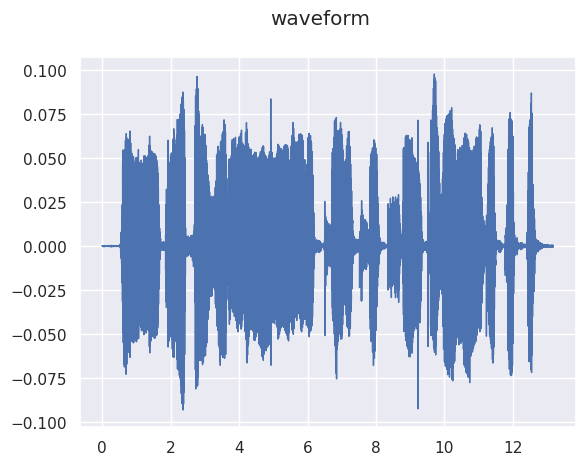

In [23]:
waveform, sample_rate = torchaudio.load(data["path_wav"][0])

def plot_waveform(waveform, sample_rate=16000):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
    
plot_waveform(waveform)

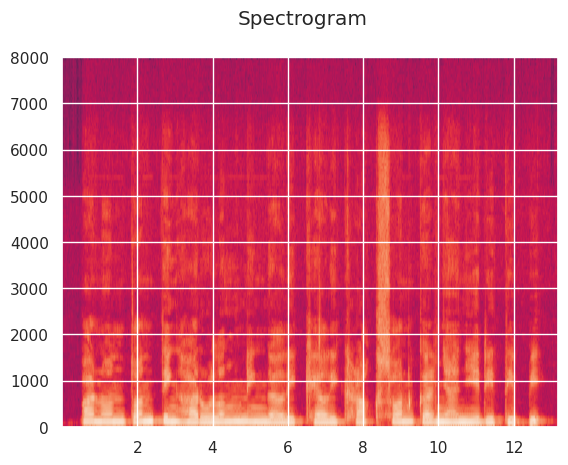

In [24]:
def plot_specgram(waveform, sample_rate=16000, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=True)
    
plot_specgram(waveform)

In [25]:
data_train, data_test = train_test_split(data, test_size=0.1)

print(f"Data training : {data_train.shape}\nData Test : {data_test.shape}")

Data training : (2160, 4)
Data Test : (241, 4)


In [26]:
dataset_train = Dataset.from_dict(data_train)
dataset_test = Dataset.from_dict(data_test)
dataset = datasets.DatasetDict({"train": dataset_train, "test": dataset_test})
dataset

DatasetDict({
    train: Dataset({
        features: ['path_wav', 'text', 'array', 'sample_rate'],
        num_rows: 2160
    })
    test: Dataset({
        features: ['path_wav', 'text', 'array', 'sample_rate'],
        num_rows: 241
    })
})

In [27]:
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [28]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [29]:
def prepare_dataset(example):

    proses = processor(
        text=example["text"],
        audio_target=example["array"],
        sampling_rate=16000,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    proses["labels"] = proses["labels"][0]

    # use SpeechBrain to obtain x-vector
    proses["speaker_embeddings"] = create_speaker_embedding(example["array"])

    return proses

In [30]:
processed_example = prepare_dataset(dataset["train"][0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [31]:
processed_example["labels"]

array([[-3.7665381, -3.606366 , -3.9295657, ..., -4.4360924, -4.5829005,
        -4.489181 ],
       [-3.6018517, -3.3962066, -3.8704882, ..., -4.3560915, -4.5214677,
        -4.42418  ],
       [-3.5685894, -3.3578286, -3.7013261, ..., -4.358048 , -4.4680505,
        -4.4107184],
       ...,
       [-2.9274065, -2.9673398, -3.1141675, ..., -4.20966  , -4.1615267,
        -4.2545805],
       [-2.9904463, -3.162086 , -3.4758017, ..., -4.2943563, -4.2277555,
        -4.310972 ],
       [-3.12728  , -3.2026777, -3.346012 , ..., -4.2582407, -4.2781615,
        -4.3596954]], dtype=float32)

In [32]:
processed_example["speaker_embeddings"].shape

(512,)

In [33]:
processed_example["labels"]

array([[-3.7665381, -3.606366 , -3.9295657, ..., -4.4360924, -4.5829005,
        -4.489181 ],
       [-3.6018517, -3.3962066, -3.8704882, ..., -4.3560915, -4.5214677,
        -4.42418  ],
       [-3.5685894, -3.3578286, -3.7013261, ..., -4.358048 , -4.4680505,
        -4.4107184],
       ...,
       [-2.9274065, -2.9673398, -3.1141675, ..., -4.20966  , -4.1615267,
        -4.2545805],
       [-2.9904463, -3.162086 , -3.4758017, ..., -4.2943563, -4.2277555,
        -4.310972 ],
       [-3.12728  , -3.2026777, -3.346012 , ..., -4.2582407, -4.2781615,
        -4.3596954]], dtype=float32)

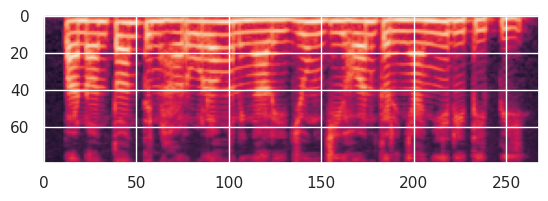

In [34]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [35]:
dataset["train"] = dataset["train"].map(prepare_dataset)
dataset["test"] = dataset["test"].map(prepare_dataset)

  0%|          | 0/2160 [00:00<?, ?ex/s]

  0%|          | 0/241 [00:00<?, ?ex/s]

In [36]:
dataset["train"], dataset["test"]

(Dataset({
     features: ['path_wav', 'text', 'array', 'sample_rate', 'input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 2160
 }),
 Dataset({
     features: ['path_wav', 'text', 'array', 'sample_rate', 'input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 241
 }))

In [37]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [38]:
data_collator = TTSDataCollatorWithPadding(processor=processor)
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [39]:
# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [43]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"text_to_speech_ind_sundanese2",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [44]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

Cloning https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese2 into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/558M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 4.00k/4.00k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/4.00k [00:00<?, ?B/s]

Download file spm_char.model:   3%|3         | 8.00k/233k [00:00<?, ?B/s]

Download file runs/Aug29_01-51-56_cd4a20274a33/events.out.tfevents.1693273921.cd4a20274a33.28.0:  32%|###2    …

Clean file runs/Aug29_01-51-56_cd4a20274a33/events.out.tfevents.1693273921.cd4a20274a33.28.0:   4%|4         |…

Clean file spm_char.model:   0%|          | 1.00k/233k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/558M [00:00<?, ?B/s]

In [45]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.484600,0.432321
2000,0.454900,0.417613
3000,0.443700,0.413499
4000,0.439600,0.413749


TrainOutput(global_step=4000, training_loss=0.48084918785095215, metrics={'train_runtime': 8260.8311, 'train_samples_per_second': 15.495, 'train_steps_per_second': 0.484, 'total_flos': 1.016342226768528e+16, 'train_loss': 0.48084918785095215, 'epoch': 59.26})

In [46]:
trainer.push_to_hub()

Upload file runs/Aug29_03-59-32_10cd896e282d/events.out.tfevents.1693281738.10cd896e282d.28.0:   0%|          …

To https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese2
   3d37d83..b6a42ba  main -> main

To https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese2
   b6a42ba..b5e9a90  main -> main



'https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese2/commit/b6a42ba624b6a920de2e5e2973fe18c7fd7492c9'

In [47]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "hendrimardani/text_to_speech_ind_sundanese2"
)

In [50]:
def sample(dataset):
    hasil_speaker = torch.tensor(dataset["speaker_embeddings"]).unsqueeze(0)
    return hasil_speaker

speaker_embeddings = sample(dataset["test"][0])

In [51]:
# example = dataset["test"][0]
# speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [79]:
text = "abdi orang sunda atuh"
inputs = processor(text=text, return_tensors="pt")

In [80]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [81]:
Audio(speech.numpy(), rate=16000)

In [75]:
# save audio output

import soundfile as sf

audio = speech.numpy()
sf.write("output.wav", audio, 16000)